Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15 minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them

In [79]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas import Grouper
import datetime as dt
import seaborn as sns

plt.style.use('ggplot')

In [80]:
#load json file into a pandas df
logins = pd.read_json('logins.json')

In [81]:
#check out the df: looks like we have just one column 'login_time'
logins.head() 

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [82]:
#get info on df: there are 93142 entries, none are null, and all values are datetime[ns] objects
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [83]:
logins.describe(datetime_is_numeric=False)

/var/folders/f3/x3f7tys571xbbpmnr9jwdnpr0000gn/T/ipykernel_20948/1846709858.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  logins.describe(datetime_is_numeric=False)


,login_time
count,93142
unique,92265
top,1970-03-17 01:01:39
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


We can see from the summary that not all datetime values are unique--the largest amount of non-unique dt logins is 3--that is, at most there are 3 login entries for the exact same time. There are a total of 877 repeated login times. However, we have no way to tell if these logins are from different users at exactly the same time, or are true duplicates that should be removed. Going to leave them in for now.

We also see the time series begins on 01-01-1970 and ends on 04-13-1970, so it's about 4 and half months-worth of login data.

Now let's get this df ready to aggregate by 15 minute windows. I'm going to add a column to hold one count for each login, then aggregate the resulting df by 15 minute intervals to get the sum of logins for each timeframe.

In [84]:
#add a count column to aggregate
logins['count']=1

#use pandas' Grouper function to make quick work of defining the 15 minute time window and aggregate the counts for each.
q_hourly = pd.DataFrame(logins.groupby([Grouper(key='login_time', freq='15Min')]).sum())

#rename "count" column to "logins"
q_hourly.rename(columns={'count':'logins'}, inplace=True)

#reset index
q_hourly.reset_index(inplace=True)

#check our work:
q_hourly.head()

,login_time,logins
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


looks good, we can see the aggregation began at the first login time. lets get a sum of counts to make sure all the original logins are still accounted for:

In [85]:
print(q_hourly['logins'].sum() == len(logins))

True


Now let's begin our visualization:

In [86]:
#create a series, y, to hold the counts of use logins at each time
from statistics import mean

y = q_hourly['logins']

#get descriptive characteristics of y
print(y.describe())

print('the number of 15-minute intervals is: {}'.format(y.count()))
print('the maximum number of logins in a single interval is: {}'.format(y.max()))
print('the minimum number of logins in a single interval is: {}'.format(y.min()))
print('the mean number of logins in a single interval is: {}'.format(round(y.mean(),2)))

count    9788.000000
mean        9.515938
std         8.328818
min         0.000000
25%         3.000000
50%         7.000000
75%        13.000000
max        73.000000
Name: logins, dtype: float64
the number of 15-minute intervals is: 9788
the maximum number of logins in a single interval is: 73
the minimum number of logins in a single interval is: 0
the mean number of logins in a single interval is: 9.52


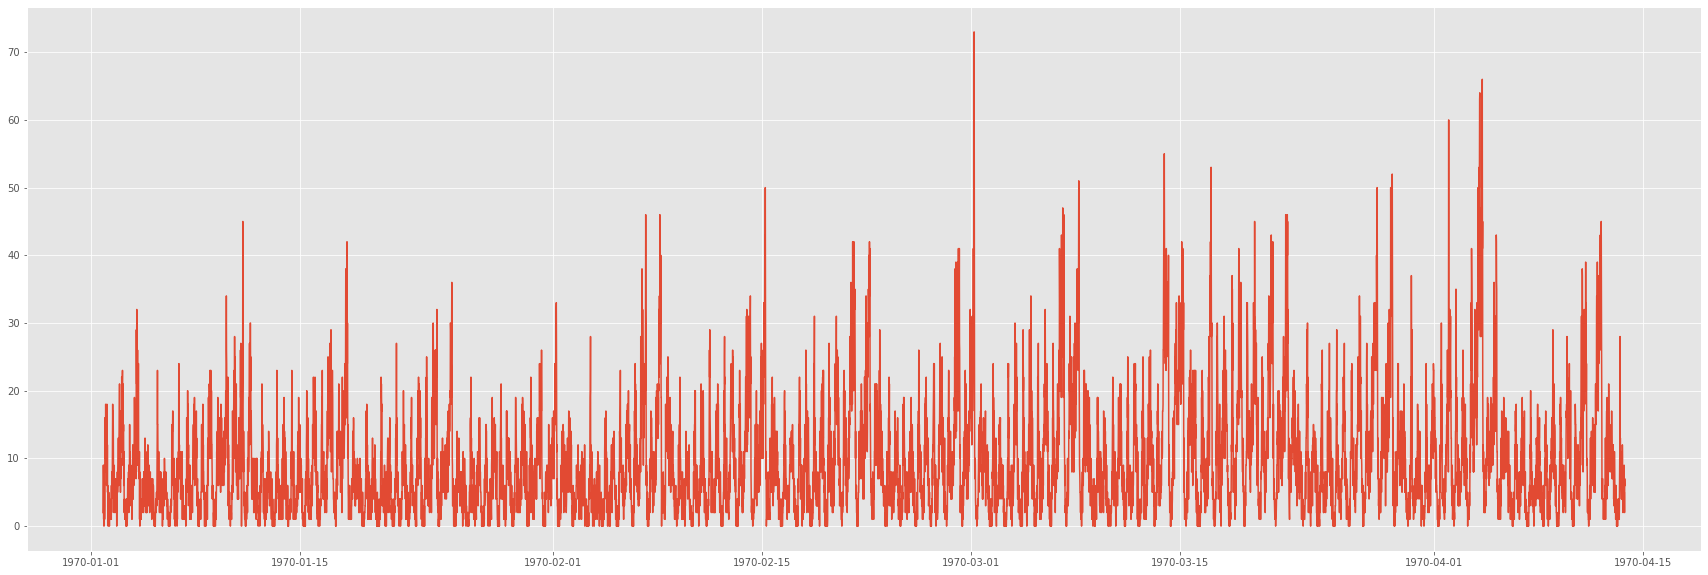

In [87]:
#plot overall time series

_ = plt.figure(figsize=(30,10))
_ = plt.plot(q_hourly['login_time'], y)

plt.show()

So this is what the overall time data looks like, where x is the time broken into 15 minute intervals and y is the number of logins at each interval. Messy, but we can see that the overall data looks stationary and has some sort of seasonality. Let's break down the time data into days, weeks and months to visualize the seasonality of each one.

In [88]:
q_hourly['day_of_month'] = q_hourly['login_time'].dt.day
q_hourly['month'] = q_hourly['login_time'].dt.month
q_hourly['month_name'] = q_hourly['login_time'].dt.month_name()
q_hourly['day_of_week'] = q_hourly['login_time'].dt.dayofweek
q_hourly['day_name'] = q_hourly['login_time'].dt.day_name()
q_hourly['is_weekend'] = np.where(q_hourly['day_name'].isin(['Sunday', 'Saturday']),'weekend','weekday')
q_hourly['hour'] = q_hourly['login_time'].dt.hour
q_hourly['minute'] = q_hourly['login_time'].dt.minute
q_hourly['hour_and_minute'] = q_hourly['login_time'].dt.strftime('%H:%M')

In [89]:
q_hourly.head()

,login_time,logins,day_of_month,month,month_name,day_of_week,day_name,is_weekend,hour,minute,hour_and_minute
0,1970-01-01 20:00:00,2,1,1,January,3,Thursday,weekday,20,0,20:00
1,1970-01-01 20:15:00,6,1,1,January,3,Thursday,weekday,20,15,20:15
2,1970-01-01 20:30:00,9,1,1,January,3,Thursday,weekday,20,30,20:30
3,1970-01-01 20:45:00,7,1,1,January,3,Thursday,weekday,20,45,20:45
4,1970-01-01 21:00:00,1,1,1,January,3,Thursday,weekday,21,0,21:00


/var/folders/f3/x3f7tys571xbbpmnr9jwdnpr0000gn/T/ipykernel_20948/3711742788.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])


[Text(-1.0, 0, '0'),
 Text(0.0, 0, 'Monday'),
 Text(1.0, 0, 'Tuesday'),
 Text(2.0, 0, 'Wednesday'),
 Text(3.0, 0, 'Thursday'),
 Text(4.0, 0, 'Friday'),
 Text(5.0, 0, 'Saturday'),
 Text(6.0, 0, 'Sunday'),
 Text(7.0, 0, '')]

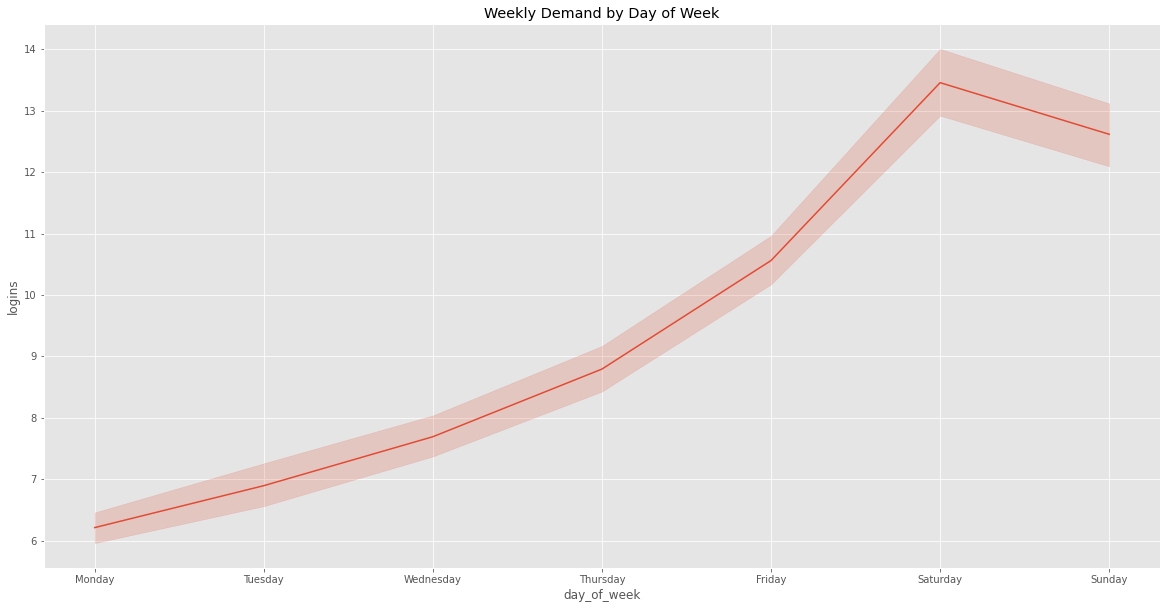

In [90]:
#plot weekly rhythms of demand
plt.figure(figsize=(20,10))
ax = sns.lineplot(data = q_hourly, x = 'day_of_week', y = 'logins')
plt.title('Weekly Demand by Day of Week')
ax.set_xticklabels([0, 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])


We can see from this plot that the average number of logins/quarter hour steadily increases through the week from Monday (0) to Friday (4) before hitting a peak on Saturday and falling slightly on Sunday. We can tell from this that our greatest demand for rides is on weekends, and our lowest demand is on Monday. This is pretty high level, though. Let's try stratifying by the hour of day to see if we can get a more detailed picture of rider behavior.

/var/folders/f3/x3f7tys571xbbpmnr9jwdnpr0000gn/T/ipykernel_20948/3026564411.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])


[Text(-1.0, 0, '0'),
 Text(0.0, 0, 'Monday'),
 Text(1.0, 0, 'Tuesday'),
 Text(2.0, 0, 'Wednesday'),
 Text(3.0, 0, 'Thursday'),
 Text(4.0, 0, 'Friday'),
 Text(5.0, 0, 'Saturday'),
 Text(6.0, 0, 'Sunday'),
 Text(7.0, 0, '')]

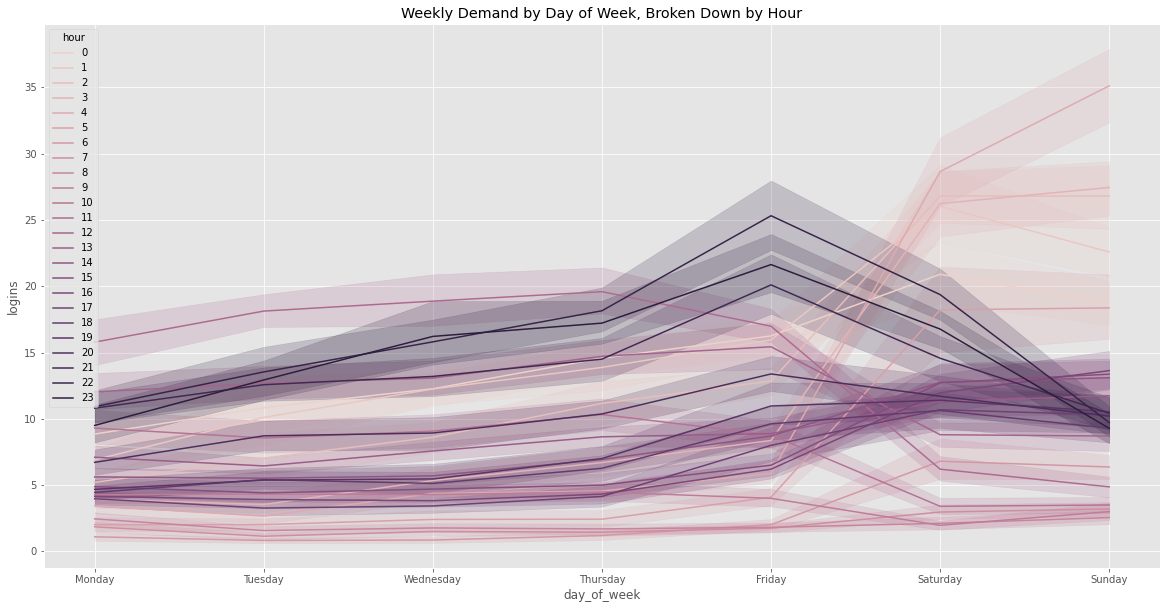

In [91]:
#plot weekly rhythms broken down by hour
plt.figure(figsize=(20,10))
ax = sns.lineplot(data = q_hourly, x = 'day_of_week', y = 'logins', hue='hour', legend = 'full')
ax.set_title('Weekly Demand by Day of Week, Broken Down by Hour')
ax.set_xticklabels([0, 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])


Wow, that's a lot to take in! It's clear that the hourly demand varies by the day of the week, but this visualization is too much to take in and get much meaning out of. I'm going to engineer a new feature in the df that will categorize the hour into a "time of day" feature. 
        

In [92]:
#create the hour groupings
conditions = [
    (q_hourly['hour']).isin([0,1,2,3,4,5]),
    (q_hourly['hour']).isin([6,7,8,9,10,11]),
    (q_hourly['hour']).isin([12, 13, 14, 15, 16, 17]),
    (q_hourly['hour']).isin([18,19,20,21,22,23])
]
#define the names to include in the new categorical feature
time_of_day = ('midnight - 5:59am', '6am - 11:59am', '12pm - 5:59pm', '6pm - 11:59pm')

#add new column with category assignments based on the conditions defined above
q_hourly['time_of_day'] = np.select(conditions,time_of_day, default=0)


/var/folders/f3/x3f7tys571xbbpmnr9jwdnpr0000gn/T/ipykernel_20948/3384478470.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])


[Text(-1.0, 0, '0'),
 Text(0.0, 0, 'Monday'),
 Text(1.0, 0, 'Tuesday'),
 Text(2.0, 0, 'Wednesday'),
 Text(3.0, 0, 'Thursday'),
 Text(4.0, 0, 'Friday'),
 Text(5.0, 0, 'Saturday'),
 Text(6.0, 0, 'Sunday'),
 Text(7.0, 0, '')]

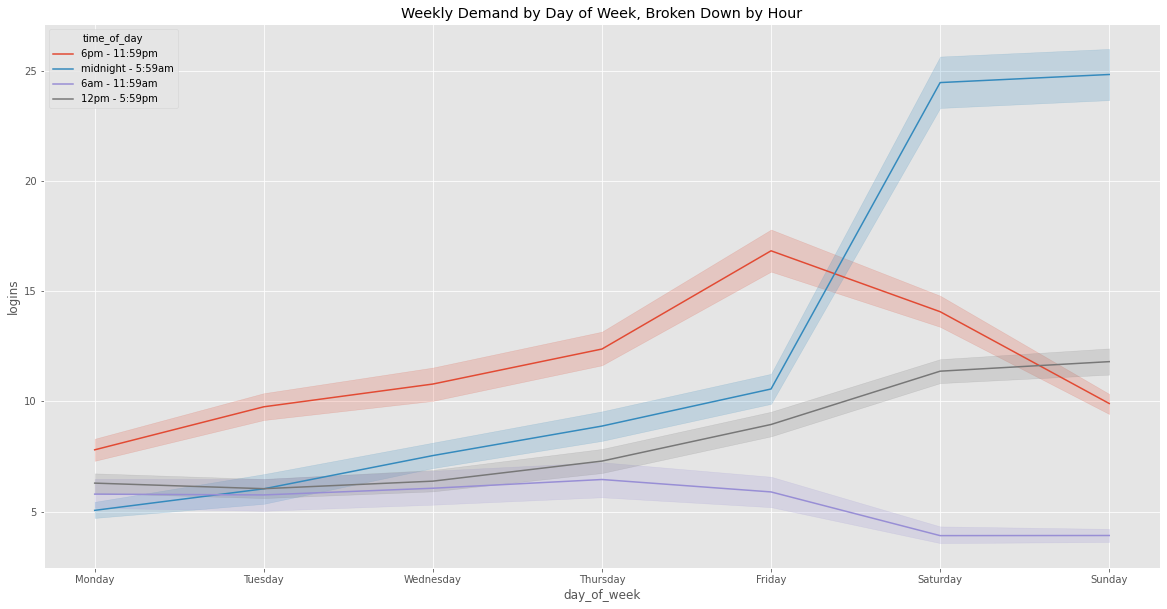

In [93]:
#plot weekly rhythms broken down by time of day
plt.figure(figsize=(20,10))
ax = sns.lineplot(data = q_hourly, x = 'day_of_week', y = 'logins', hue='time_of_day', legend = 'full')
ax.set_title('Weekly Demand by Day of Week, Broken Down by Hour')
ax.set_xticklabels([0, 'Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday'])


Now this is a cool plot; we can now see when the greatest demand is for each day of the week, broken down into the time of day. 
- We can see that the demand for 6pm - 11:59pm reaches its height on Friday nights, perhaps reflecting the users' tendency to use our service to go out at the end of the workweek. 
- We can see that the greatest hours of demand on Saturday and Sunday are from 12am - 5:59am, and also that Saturday and Sunday are the days of the week with the greatest demand during those hours **by far**. 
- We have pretty much no demand for 6am-11:59am on the weekends, though this time of day maintains a slightly higher and pretty consistent level throughout the weekdays.

We can also visualize the daily demand for each day of the week:

Text(0.5, 1.0, 'Hourly Demand by Day of Week')

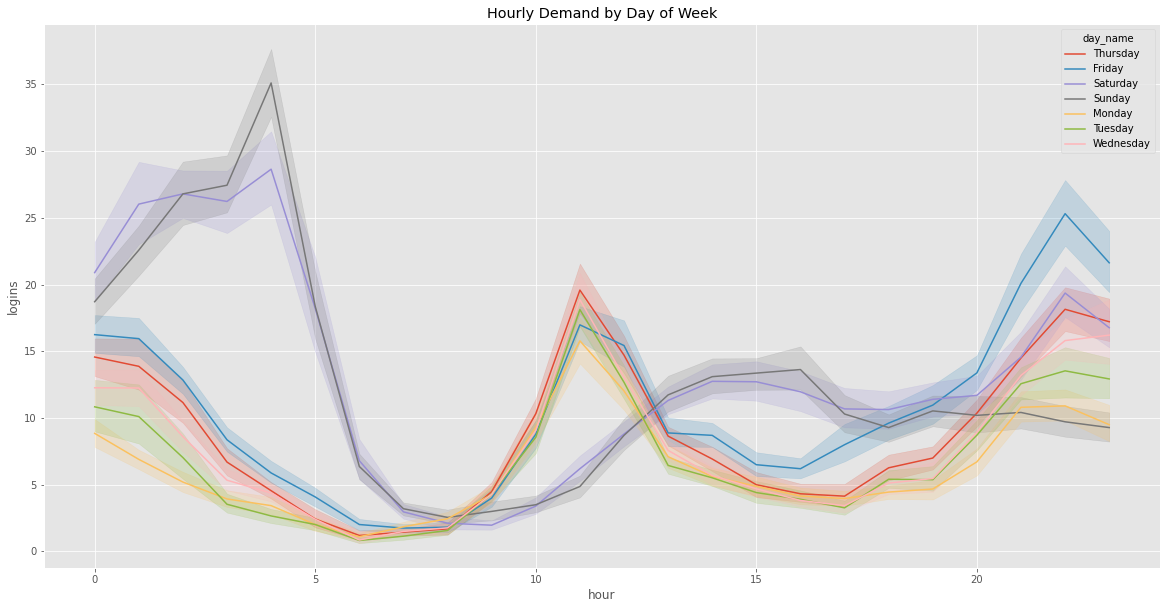

In [94]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(data = q_hourly, x = 'hour', y = 'logins', hue = 'day_name')
ax.set_title('Hourly Demand by Day of Week')

This view really illustrates the daily rhythms of demand for each day of the week. We also notice that the weekend days seem to follow their own rhythm quite distinct from the weekdays. Let's hone in on that distinction below:

Text(0.5, 1.0, 'Hourly Demand by Day of Week')

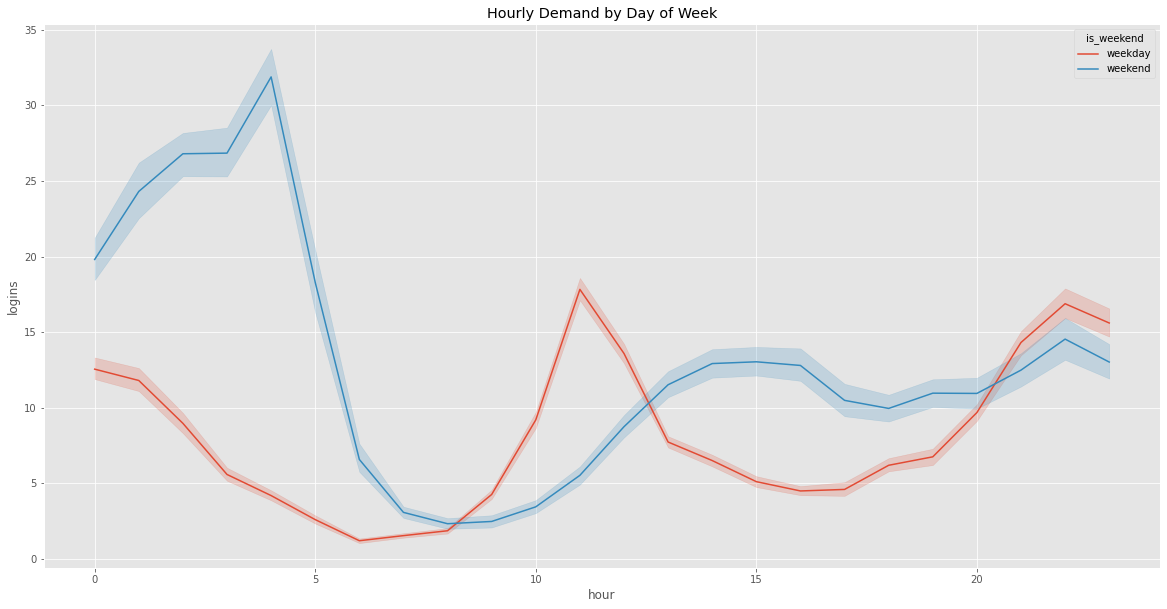

In [95]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(data = q_hourly, x = 'hour', y = 'logins', hue = 'is_weekend')
ax.set_title('Hourly Demand by Day of Week')